In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator
import glob

In [2]:
# basic params
alive_reward_scale = 2.0
progress_reward = 5.0
deathCost = -5.0

experiments = [f"Biped_final_{i}" for i in range(8)]
alive_reward_scales = 5.0
progress_rewards = [1.0, 1.0, 1.0, 1.0, 5.0, 5.0, 5.0, 5.0]
deathCosts = [-1.0, -1.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0]

experiment = "Biped_final_7"
directory = f"omniisaacgymenvs/runs/{experiment}/"
isSpeed = True
log_file = directory + f"{experiment}.txt"
tensor_file = directory + f"summaries/*.alex-Blade"
tensor_file = glob.glob(tensor_file)[-1]
col_names = ["Ave Reward", "Progress Reward", "Alive Reward",
              "Up Reward", "Heading Reward", "Action Cost",
              "Energy Cost", "DOF Limit Cost"]
if isSpeed: col_names = col_names + ["Speed Reward"]

In [4]:
# parse log and make pd df
def get_parse_log(experiment):
    directory = f"omniisaacgymenvs/runs/{experiment}/"
    log_file = directory + f"{experiment}.txt"

    df = []
    with open(log_file, 'r') as f:
        row = []
        for line in f:
            split = line.split(":")
            rew_type, val = split[0], split[1].strip()
            
            if rew_type[:4] != "Step":
                row.append(float(val))
            else:
                df.append(row)
                row = []

    df = pd.DataFrame(df[1:][:])
    df.columns = col_names
    df = df.reset_index()
    return df

In [5]:
dfs = []
for x in experiments:
    x_df = get_parse_log(x)
    dfs.append(x_df)

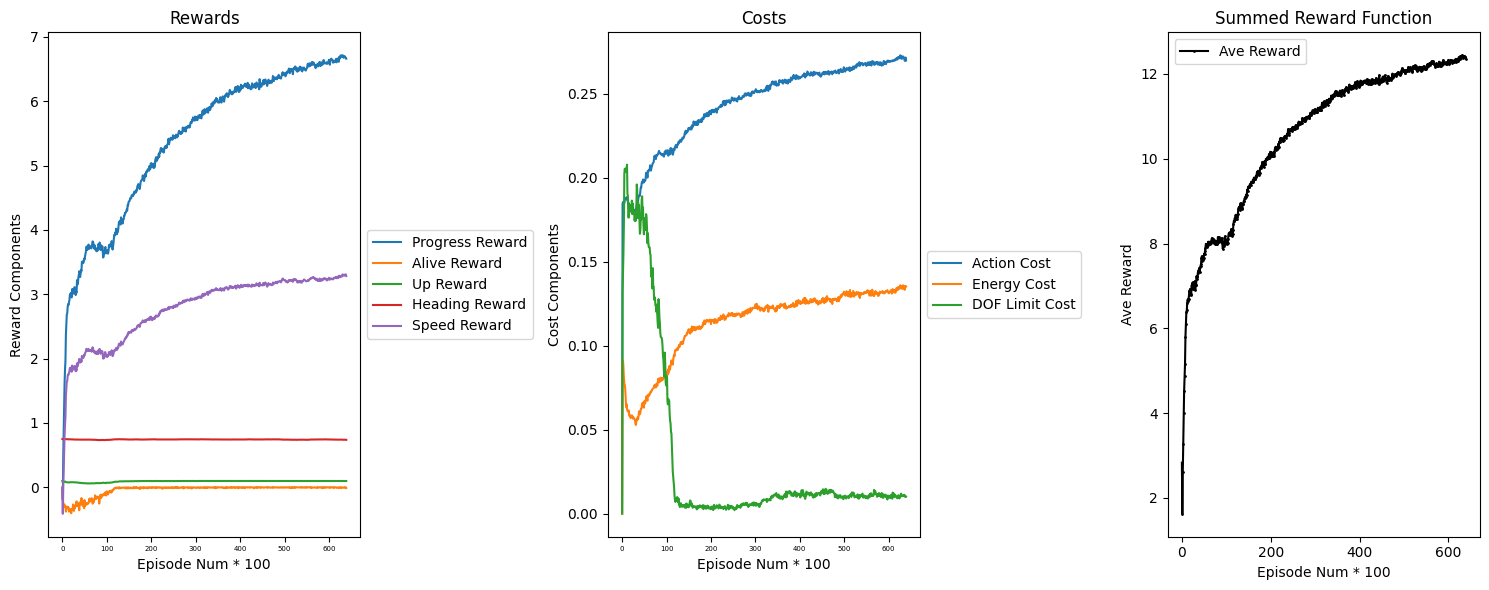

In [61]:
# plot
# Create a bar chart for stacked categories
df = get_parse_log(experiment = "Biped_final_7")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

# set cols
line_cols = ['Ave Reward', 'index']
reward_cols = ["Progress Reward", "Alive Reward",
              "Up Reward", "Heading Reward"]
if isSpeed: reward_cols = reward_cols + ["Speed Reward"]
cost_cols = ["Action Cost", "Energy Cost", "DOF Limit Cost"]
reward_cols.append('index')
cost_cols.append('index')

df[reward_cols].plot(x='index', kind='line', stacked=False, ax=ax1)
ax1.set_xlabel('Episode Num * 100')
ax1.tick_params(axis='x', labelsize=5)
ax1.set_ylabel('Reward Components')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_title('Rewards')

df[cost_cols].plot(x='index', kind='line', stacked=False, ax=ax2)
ax2.set_xlabel('Episode Num * 100')
ax2.tick_params(axis='x', labelsize=5)
ax2.set_ylabel('Cost Components')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.set_title('Costs')

# Create a line plot for 'Ave Reward'
df[line_cols].plot(x='index', kind='line', color='black', marker='o', ax=ax3, markersize=1)
ax3.set_xlabel('Episode Num * 100')
ax3.set_ylabel('Ave Reward')
ax3.set_title('Summed Reward Function')

plt.tight_layout()
plt.savefig(f"plots/{experiment}_reward.png")
plt.show()



In [ ]:
# (total_reward / deathCost)

# plot
# Create a bar chart for absolute comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# set cols
prog_plt = ['Progress Reward', 'index']
alive_plt = ['Alive Reward', 'index']

(df[prog_plt]/progress_reward).plot(x='index', kind='line', stacked=False, ax=ax1)
ax1.set_xlabel('Episode Num * 100')
ax1.tick_params(axis='x', labelsize=5)
ax1.set_ylabel('Progress Made')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_title('Progress')

(df[alive_plt]/deathCost).plot(x='index', kind='line', stacked=False, ax=ax2)
ax2.set_xlabel('Episode Num * 100')
ax2.tick_params(axis='x', labelsize=5)
ax2.set_ylabel('Duration Alive')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.set_title('Alive')

plt.tight_layout()
plt.savefig(f"plots/{experiment}_metrics.png")
plt.show()

In [35]:
# plot
# Create a bar chart for absolute comparison
def comparison_plots(dfs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))\
    # set cols
    prog_plt = ['Progress Reward', 'index']
    alive_plt = ['Alive Reward', 'index']

    experiments = [f"Biped_{i}" for i in range(8)]
    for i, df in enumerate(dfs):
        (df[prog_plt]/progress_reward).plot(x='index', kind='line', 
                                            stacked=False, ax=ax1,
                                            linewidth=1, alpha=0.75)
        (df[alive_plt]/deathCost).plot(x='index', kind='line', 
                                       stacked=False, ax=ax2,
                                       linewidth=1, alpha=0.75)
        
    ax1.set_xlabel('Episode Num * 100')
    ax1.tick_params(axis='x', labelsize=5)
    ax1.set_ylabel('Progress Made')
    ax1.legend(experiments, loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.set_title('Progress')

    ax2.set_xlabel('Episode Num * 100')
    ax2.tick_params(axis='x', labelsize=5)
    ax2.set_ylabel('Duration Alive')
    ax2.legend(experiments, loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.set_title('Alive')

    plt.tight_layout()
    plt.savefig(f"plots/compare_metrics.png")
    plt.show()



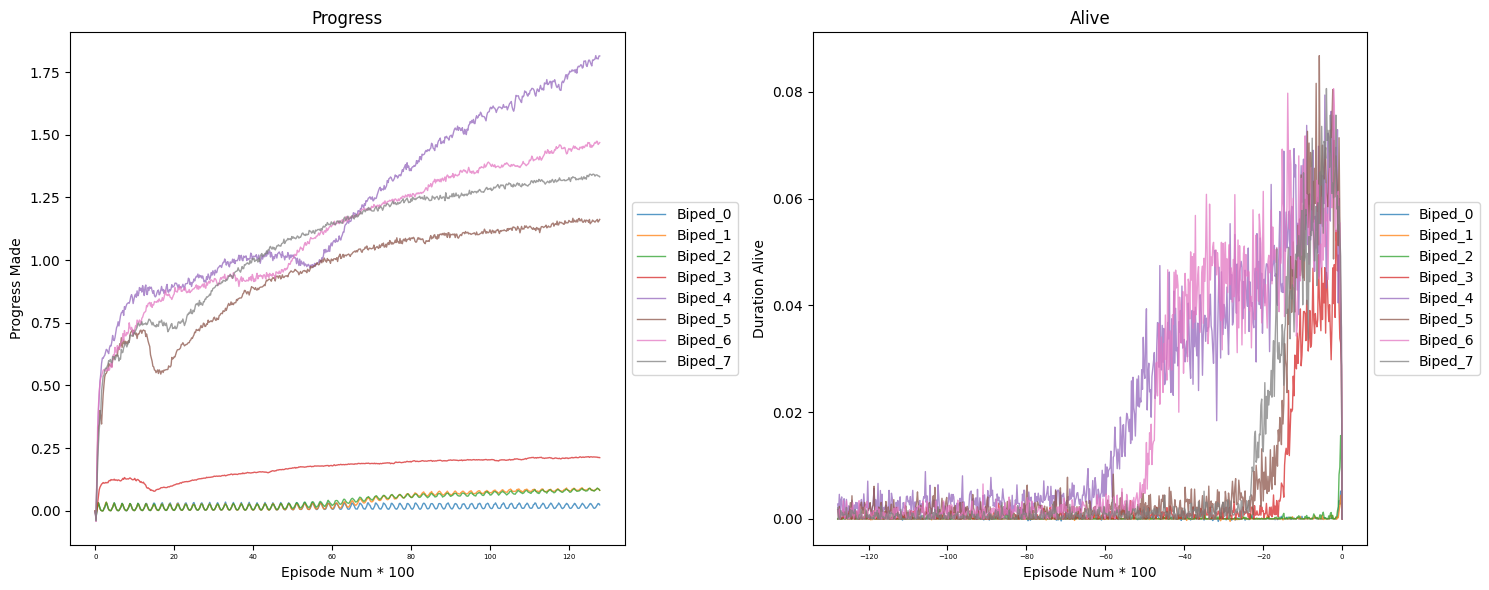

In [36]:
comparison_plots(dfs)

In [63]:
event_acc = event_accumulator.EventAccumulator(tensor_file)
event_acc.Reload()

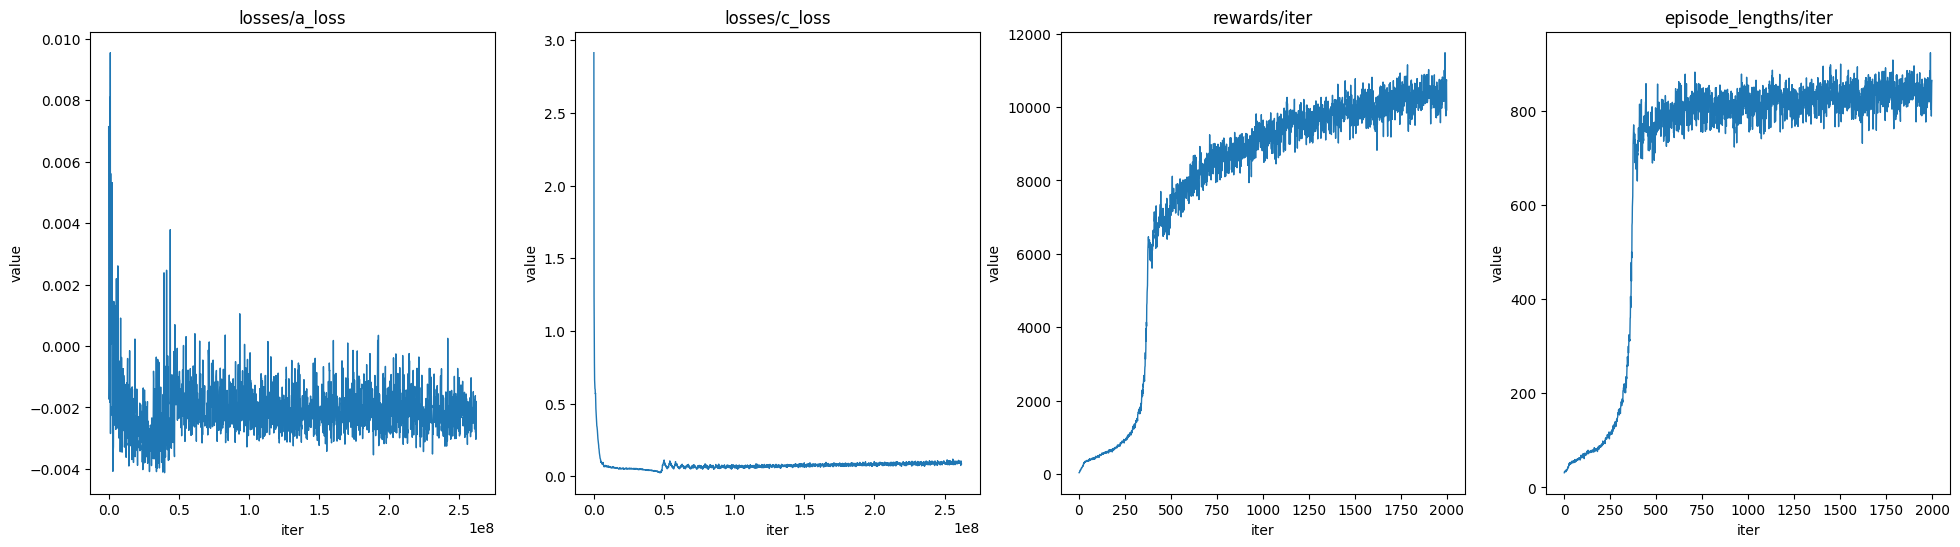

In [64]:
# scalar_tags = event_acc.Tags()['scalars']
scalar_tags = ['losses/a_loss', 'losses/c_loss', 'rewards/iter', 'episode_lengths/iter']
scalar_data = {tag: event_acc.Scalars(tag) for tag in scalar_tags}

fig, axs = plt.subplots(1, 4, figsize=(24, 6))
for i, (tag, data) in enumerate(scalar_data.items()):
    steps = [entry.step for entry in data]
    values = [entry.value for entry in data]
    ax = axs[i]
    ax.plot(steps, values, label=tag, linewidth=1)
    ax.set_title(tag)
    ax.set_xlabel('iter')
    ax.set_ylabel('value')
plt.savefig(f"plots/{experiment}_tensor.png")
plt.show()